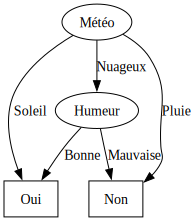


=== Divisions utilisées dans l'arbre ===
  Attribut  Entropie globale  Gain d'information  Taille du nœud
0    Météo          0.954434            0.704434               8
1   Humeur          1.000000            1.000000               2


In [12]:
import numpy as np
import pandas as pd
from collections import Counter
from graphviz import Digraph
from IPython.display import display

class ID3Classifier:
    def __init__(self):
        self.tree_ = None
        self.splits_ = []  # Journal des splits

    def _entropy(self, y):
        counts = np.array(list(Counter(y).values()))
        probs = counts / counts.sum()
        return -(probs * np.log2(probs)).sum()

    def _info_gain(self, df, attr, target):
        base_ent = self._entropy(df[target])
        vals, counts = np.unique(df[attr], return_counts=True)
        weighted_ent = 0.0
        for v, c in zip(vals, counts):
            subset = df[df[attr] == v][target]
            weighted_ent += (c / counts.sum()) * self._entropy(subset)
        return base_ent - weighted_ent

    def _build_tree(self, df, features, target):
        y = df[target]
        if len(set(y)) == 1:
            return y.iloc[0]
        if not features:
            return Counter(y).most_common(1)[0][0]

        gains = [(self._info_gain(df, f, target), f) for f in features]
        best_gain, best_attr = max(gains, key=lambda x: x[0])
        if best_gain == 0:
            return Counter(y).most_common(1)[0][0]

        # Log du split
        self.splits_.append({
            'Attribut': best_attr,
            'Entropie globale': self._entropy(df[target]),
            'Gain d\'information': best_gain,
            'Taille du nœud': len(df)
        })

        tree = {best_attr: {}}
        remaining = [f for f in features if f != best_attr]

        for val in df[best_attr].unique():
            subset = df[df[best_attr] == val]
            if subset.empty:
                tree[best_attr][val] = Counter(y).most_common(1)[0][0]
            else:
                tree[best_attr][val] = self._build_tree(subset, remaining, target)
        return tree

    def fit(self, df: pd.DataFrame, features: list, target: str):
        self.tree_ = self._build_tree(df, features, target)
        return self

    def print_tree(self, tree=None, indent=""):
        if tree is None:
            tree = self.tree_
        if not isinstance(tree, dict):
            print(indent + "→", tree)
        else:
            attr = next(iter(tree))
            for val, subtree in tree[attr].items():
                print(f"{indent}{attr} = {val}")
                self.print_tree(subtree, indent + "    ")

    def visualize(self, filename="id3_tree"):
        dot = Digraph(format='png')
        def recurse(node, parent=None, edge_label=None):
            if isinstance(node, dict):
                attr = next(iter(node))
                uid = str(id(node))
                dot.node(uid, label=attr, shape='ellipse')
                if parent is not None:
                    dot.edge(parent, uid, label=edge_label)
                for val, child in node[attr].items():
                    recurse(child, uid, str(val))
            else:
                leaf_id = f"leaf_{id(node)}"
                dot.node(leaf_id, label=str(node), shape='box')
                dot.edge(parent, leaf_id, label=edge_label)

        recurse(self.tree_)
        display(dot)           # Affiche dans un notebook
        dot.render(filename)   # Sauvegarde PNG

    def get_splits_dataframe(self):
        """Retourne un DataFrame listant les splits (divisions) utilisés dans l'arbre."""
        return pd.DataFrame(self.splits_)

# --------------------
# Execution
# --------------------
if __name__ == "__main__":
    df = pd.read_csv('data_revision.csv')

    features = ['Météo','Humeur','Temps libre']
    target = 'Révision'

    clf = ID3Classifier().fit(df, features, target)

    # print("=== Arbre ID3 (ASCII) ===")
    # clf.print_tree()

    clf.visualize("arbre_etudiant")  # Affiche + sauvegarde PNG

    # Récupérer et afficher les splits
    df_splits = clf.get_splits_dataframe()
    print("\n=== Divisions utilisées dans l'arbre ===")
    print(df_splits)
